In [1]:
import sys
import os
import tensorflow as tf

sys.path.insert(0, "..")
os.environ['SM_FRAMEWORK']='tf.keras' 
tf.config.list_physical_devices('GPU')
import matplotlib.pyplot as plt
from rlxutils import subplots
from collections import OrderedDict
from lib.experiments import runs, metrics
from lib.data import dataloaders, chipset
from lib.experiments import plots
import numpy as np
from importlib import reload
from progressbar import progressbar as pbar
import pandas as pd
import geopandas as gpd
import shapely as sh
basedir="/opt/data"
#basedir="/home/rlx/data/

reload(dataloaders)
reload(runs)

2023-05-13 08:29:00.005456: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 08:29:00.421399: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-13 08:29:00.421418: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-13 08:29:00.498531: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-13 08:29:02.088399: W tensorflow/stream_executor/platform/de

Segmentation Models: using `tf.keras` framework.
unit testing metrics


2023-05-13 08:29:04.662328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<module 'lib.experiments.runs' from '/home/rlx/Dropbox/working/eo-label-proportions/qm4labelproportions/notebooks/../lib/experiments/runs.py'>

In [2]:

benelux_images  = ['213835e49ff19', '1c0757134c0e6', '103e9a059d1a7', '176dc682642c0', '241e26ca89a1f', '103e9a059d1a7', '1450937192b98', '1a6945c885054', '1ff8b40320e9c', '387cf5935626e']
colombia_images = ['224105df357ca', '1fc2740726605', '2c0d8f29875c6', '3035896f65809', '2af9262ae0588', '01421a0f7b58e', '2342e72c0eecd', '1728f6dd31b43', '26023845ccf97', '1b8ff84920f2a' ]

colombia_esaworldcover_models_mse = {'eimikgrw': 'downconv mse',
                                     't42ibkzv': 'qmpatch mse',
                                     'gq5a3qyv': 'vgg16 mse'}
colombia_esaworldcover_models_pcxe = {
                                     'jx5kourl': 'downconv pxce',
                                     'o8iyayns': 'vgg16 pxce',
                                     }

benelux_esaworldcover_models_mse = {'18uwzkax': 'downconv mse',
                                    'lwoteex7': 'qmpatch mse',
                                    '1t6sd9f2': 'vgg16 mse'}

benelux_esaworldcover_models_pcxe = {
                                     'vi1zu35v': 'downconv pxce',
                                     'gjxzlyti': 'vgg16 pxce',
                                    }
                                }

benelux_humanpop_models_mse = {'jnevh201': 'qmpatch mse',
                               'pgziqgx0': 'vgg16 mse',
                                'g9x7v31k': 'downconv mse',
                                'wce7s8uk': 'qmpatch mse',
                               }

# Plot several models inference on the same set of input images

In [3]:
def plot_inferences (model_specs, image_ids):

    mruns = {}
    loader_class_name = None
    for modelid in model_specs.keys():
        run = runs.Run.load_from(f"/opt/data/models/{modelid}.params")
        run.dataloader_split_args['shuffle'] = False
        run.initialize()

        if loader_class_name is None:
            loader_class_name = run.tr.__class__.__name__

        elif run.tr.__class__.__name__ != loader_class_name:
            raise ValueError("all runs must have the same loader")


        mruns[modelid] = run

    r = list(mruns.values())[0]
    r.tr.enhance = True
    dataset_name = r.tr.get_name()
    nclasses = r.number_of_classes
    x, (p,l) = r.tr.get_by_ids(image_ids)

    # first gather all predictions
    outp = []
    outs = []
    models   = []
    modelids = []
    for mid,r in mruns.items():
        if r.tr.get_name()!=dataset_name:
            raise ValueError(f"all datasets must be '{dataset_name}' but found '{r.tr.get_name()}'")

        xx, ll = r.normitem(x,l)
        outp.append(r.model(xx).numpy())
        outs.append(r.model.predict_segmentation(xx).numpy())
        models.append(r)
        modelids.append(mid)

    # then plot them all
    nimgs = len(x)
    nmodels = len(mruns)
    for ax,i in subplots( nimgs * (nmodels + 2), n_cols=nimgs, usizex=3, usizey=2.5):
        nrow = i//nimgs
        ncol = i%nimgs

        if nrow==0:
            plots.plot_img(x[ncol])
            plt.title(image_ids[ncol])
        elif nrow==1:
            plots.plot_label(nclasses, l[ncol], ylabel='ground truth' if ncol==0 else None)
        else:
            plots.plot_segmentation_probabilities(models[nrow-2], 
                                                  l[ncol], 
                                                  outp[nrow-2][ncol], 
                                                  outs[nrow-2][ncol], 
                                                  include_f1=True, 
                                                  include_mae=True,
                                                  ylabel = model_specs[modelids[nrow-2]] if ncol==0 else None)
        plt.axis("on")
        plt.xticks([],[])
        plt.yticks([],[])
                

In [ ]:
plot_inferences(colombia_esaworldcover_models_mse, colombia_images)

In [ ]:
plot_inferences(colombia_esaworldcover_models_pcxe, colombia_images)

In [ ]:
plot_inferences(benelex_esaworldcover_models_mse, benelux_images)

In [ ]:
plot_inferences(benelex_esaworldcover_models_pcxe, benelux_images)

# benelux example images

In [4]:
reload(dataloaders)

<module 'lib.data.dataloaders' from '/home/rlx/Dropbox/working/eo-label-proportions/qm4labelproportions/notebooks/../lib/data/dataloaders.py'>

In [ ]:
tr, ts, val = dataloaders.S2_HumanPopulation_DataLoader.split_per_partition(basedir="/opt/data/colombia-ne/colombia-ne_sentinel2-rgb-median-2020_humanpop2015", partitions_id='communes', enhance=True)


In [ ]:
chipids = np.random.permutation(ts.chips_basedirs)[:10]
x, (p,l) = val.get_by_ids(chipids)
for ax,i in subplots(len(x)):
    plt.imshow(x[i])
for ax,i in subplots(len(x)):
    plt.imshow(l[i], vmin=0, vmax=2)

In [ ]:
colombia_images = ['224105df357ca', '1fc2740726605', '2c0d8f29875c6', '3035896f65809', '2af9262ae0588', '01421a0f7b58e', '2342e72c0eecd', '1728f6dd31b43', '26023845ccf97', '1b8ff84920f2a' ]


In [ ]:
reload(dataloaders)

hp = dataloaders.S2_HumanPopulation_DataLoader("/home/rlx/data/benelux/benelux_sentinel2-rgb-median-2020_humanpop2015/")
lc = dataloaders.S2_ESAWorldCover_DataLoader("/home/rlx/data/benelux/benelux_sentinel2-rgb-median-2020_esa-world-cover/")

loaders = [ hp, lc]

ids = ['0ec04e918873b', '1c0c81f9f3a8e', '0b8047ab410e4', '21373a632189a', '2bc09e32f26fc', '312faae96fd5f' , '270411c572aae', '1df8c2db43047','280e3c4641fc2', '16c02abe6442d']
#ids = np.random.permutation(hp.chips_basedirs)[:6]
ids = benelux_images
data = [loader.get_by_ids(ids) for loader in loaders]

x, (p,l) = loaders[0].get_by_ids(ids)
"""
xe = []
for xi in x:
    percentiles = np.percentile(xi, (.5, 99.5))
    xe.append(exposure.rescale_intensity(xi, in_range=tuple(percentiles)))
x = xe
"""
n = len(loaders)
m = len(ids)
for ax,i in subplots(m*(n+1), n_cols=m, usizex=2.5, usizey=2):
    if i<m:
        plots.plot_img(x[i])
        plt.title(ids[i])
        if i==0:
            plt.ylabel("RGB input")
    else:
        loader = loaders[(i-m)//m]
        x,(p,l) = data[(i-m)//m]        
        plots.plot_label(loader.number_of_output_classes, l[i%m])
        if i%m==0:
            plt.ylabel(loader.get_name())
    plt.axis("on")


got  72213 chips on 2256 batches. cache size is 100
got  72213 chips on 2256 batches. cache size is 100
got  72213 chips on 2256 batches. cache size is 100


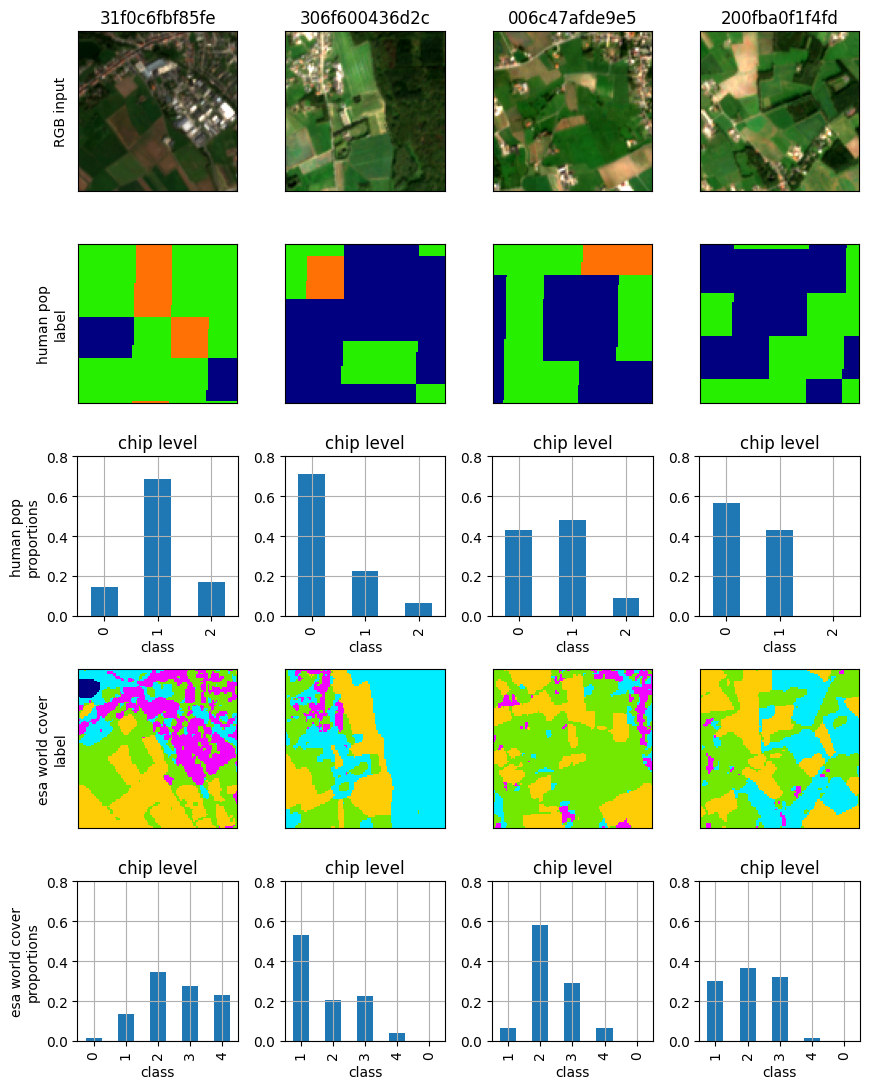

In [187]:
reload(dataloaders)

hp = dataloaders.S2_HumanPopulation_DataLoader("/home/rlx/data/benelux/benelux_sentinel2-rgb-median-2020_humanpop2015/", partitions_id='communes' , enhance=True)
lc = dataloaders.S2_ESAWorldCover_DataLoader("/home/rlx/data/benelux/benelux_sentinel2-rgb-median-2020_esa-world-cover/", partitions_id='communes')

loaders = [hp, lc]

ids = ['0ec04e918873b', '1c0c81f9f3a8e', '0b8047ab410e4', '21373a632189a', '2bc09e32f26fc', '312faae96fd5f' , '270411c572aae', '1df8c2db43047','280e3c4641fc2', '16c02abe6442d']
ids = ['31f0c6fbf85fe',
 '306f600436d2c',
 '006c47afde9e5',
 '200fba0f1f4fd']

#ids = np.random.permutation(hp.chips_basedirs)[:6]
#ids = benelux_images[:8]
data = [loader.get_by_ids(ids) for loader in loaders]

x, (p,l) = loaders[0].get_by_ids(ids)
n = len(loaders)
m = len(ids)
for ax,i in subplots(m*(2*n+1), n_cols=m, usizex=2.2, usizey=2.2):
    row = i//m
    col = i%m
    if row==0:        
        plots.plot_img(x[i])
        plt.title(ids[i])
        plt.axis("on"); plt.xticks([], []); plt.yticks([], [])
        if i==0:
            plt.ylabel("RGB input")
    else:
        lrow = (row-1)%len(loaders)
        nloader = (row-1)//len(loaders)
        if lrow==0:
            loader = loaders[nloader]
            x,(p,l) = data[nloader]        
            plots.plot_label(loader.number_of_output_classes, l[col], add_color_bar=False)
            plt.axis("on"); plt.xticks([], []); plt.yticks([], [])
            if col==0:
                plt.ylabel(f"{loader.get_name()}\nlabel")
        if lrow==1:
            lprops = {k:v/1e4 for k,v in zip(*np.unique(l[col], return_counts=True))}
            for ii in range(loader.number_of_output_classes):
                if not ii in lprops.keys():
                    lprops[ii] = 0
                    
            #pd.DataFrame( [lprops, {k:v for k,v in zip(range(p.shape[-1]), p[col])}], index = ['chip', 'commune']).T.plot(ax=ax, kind='bar', legend=col==0)
            #pd.DataFrame( [{k:v for k,v in zip(range(p.shape[-1]), p[col])}], index = ['chip']).T.plot(ax=ax, kind='bar', legend=False)
            pd.DataFrame( [lprops], index = ['chip']).T.plot(ax=ax, kind='bar', legend=False)
            plt.ylim(0,.8)
            plt.grid();
            plt.xlabel("class")
            plt.title("chip level")
            if col==0:
                plt.ylabel(f"{loader.get_name()}\nproportions")
            
        


In [5]:
def plot_proportions(p, l, show_legend=False):
    nc = run.number_of_classes
    y_pred_proportions = run.metrics.get_y_pred_as_proportions(out.reshape(1,*out.shape), argmax=True)[0]
    onchip_proportions = run.metrics.get_class_proportions_on_masks(l.reshape(1,*l.shape))[0]

    maec = run.metrics.multiclass_proportions_mae_on_chip(l.reshape(1,*l.shape), out.reshape(1,*out.shape))

    plt.bar(np.arange(nc)-.2, p, 0.2, label="on partition", alpha=.5)
    plt.bar(np.arange(nc), onchip_proportions, 0.2, label="on chip", alpha=.5)
    plt.bar(np.arange(nc)+.2, y_pred_proportions, 0.2, label="pred", alpha=.5)
    if show_legend:
        plt.legend()
    plt.grid();
    plt.xticks(np.arange(nc), np.arange(nc));
    plt.title(f"mae {maec:.3f}")            
    plt.xlabel("class number")
    plt.ylim(0,1)
    plt.ylabel("proportions")

In [3]:
hp = dataloaders.S2_HumanPopulation_DataLoader("/home/rlx/data/colombia-ne/colombia-ne_sentinel2-rgb-median-2020_humanpop2015")


got  69193 chips on 2162 batches. cache size is 100


In [7]:
pp = [p for x,(p,l) in pbar(hp)]


100% (2162 of 2162) |####################| Elapsed Time: 0:01:37 Time:  0:01:37


# stats from satellite database (number of satellites)

In [24]:
s = pd.read_excel("/home/rlx/Downloads/UCS-Satellite-Database-5-1-2022.xls")

In [33]:
s['_detail_purpose'] = ['optical' if 'optical' in str(i).lower() else \
                        'radar' if 'radar' in str(i).lower() else \
                        'imaging' if 'imaging' in str(i).lower() else i for i in s['Detailed Purpose'].values]

In [34]:
seo = s[s.Purpose=='Earth Observation']
seo.groupby('_detail_purpose').size().sort_values(ascending=False)

_detail_purpose
optical                                               470
Meteorology, Automatic Identification System (AIS)    123
Electronic Intelligence                               115
radar                                                 102
imaging                                                62
Earth Science                                          57
Meteorology                                            48
Earth Science/Meterology                               19
Automatic Identification System (AIS)                  19
Radio Spectrum Monitoring                               5
Early Warning                                           5
Radio Frequency Monitoring                              4
Maritime Surveillance                                   3
Meteorology/Earth Science                               3
Maritime Observation                                    2
Microwave Radiometer                                    1
Surveillance                                            

In [ ]:
s.groupby('Detailed Purpose').size().sort_values(ascending=False)

In [ ]:
seo.groupby('Country/Org of UN Registry').size().sort_values(ascending=False)

# colombia example images

In [ ]:
reload(dataloaders)

hp = dataloaders.S2_HumanPopulation_DataLoader("/home/rlx/data/colombia-ne/colombia-ne_sentinel2-rgb-median-2020_humanpop2015/", enhance=True)
lc = dataloaders.S2_ESAWorldCover_DataLoader("/home/rlx/data/colombia-ne/colombia-ne_sentinel2-rgb-median-2020_esa-world-cover/", enhance=True)

loaders = [hp, lc]

ids = ['224105df357ca', '1fc2740726605', '2c0d8f29875c6', '3035896f65809', '2af9262ae0588', '01421a0f7b58e', '2342e72c0eecd', '1728f6dd31b43', '26023845ccf97', '1b8ff84920f2a' ]
ids = colombia_images
#ids = np.random.permutation(hp.chips_basedirs)[:6]
data = [loader.get_by_ids(ids) for loader in loaders]

x, (p,l) = loaders[0].get_by_ids(ids)

n = len(loaders)
m = len(ids)
for ax,i in subplots(m*(n+1), n_cols=m, usizex=2.5, usizey=2):
    if i<m:
        plots.plot_img(x[i])
        plt.title(ids[i])
        if i==0:
            plt.ylabel("RGB input")
    else:
        loader = loaders[(i-m)//m]
        x,(p,l) = data[(i-m)//m]        
        plots.plot_label(loader.number_of_output_classes, l[i%m])
        if i%m==0:
            plt.ylabel(loader.get_name())
    plt.axis("on")


# Distributions of data

In [4]:

def plot_distribution(data, title, ax=None):
    pp = []
    pl = []
    for x,(p,l) in pbar(data):
        pp.append(p)
        pl.append({v:c/np.product(l.shape) for v,c in zip(*np.unique(l, return_counts=True))})
    pp = np.r_[pp]
    pp = pp.reshape(-1, pp.shape[-1])
    pl = pd.DataFrame(pl).fillna(0)

    pl = pl.mean(axis=0)
    pl = pl.loc[range(len(pl))].values
    pp = pp.mean(axis=0)

    d = pd.DataFrame([pp,pl], index=['per chip', 'per commune']).T
    d.plot(kind='bar', ax=ax)
    plt.grid();
    plt.xlabel("class number")
    plt.title(title)
    return d

In [5]:
ch = dataloaders.S2_HumanPopulation_DataLoader(basedir="/opt/data/colombia-ne/colombia-ne_sentinel2-rgb-median-2020_humanpop2015", partitions_id='communes')
bh = dataloaders.S2_HumanPopulation_DataLoader(basedir="/opt/data/benelux/benelux_sentinel2-rgb-median-2020_humanpop2015", partitions_id='communes')
ce = dataloaders.S2_ESAWorldCover_DataLoader(basedir="/opt/data/colombia-ne/colombia-ne_sentinel2-rgb-median-2020_esa-world-cover", partitions_id='communes')
be = dataloaders.S2_ESAWorldCover_DataLoader(basedir="/opt/data/benelux/benelux_sentinel2-rgb-median-2020_esa-world-cover", partitions_id='communes')


got  69193 chips on 2162 batches. cache size is 100
got  72213 chips on 2256 batches. cache size is 100
got  69193 chips on 2162 batches. cache size is 100
got  72213 chips on 2256 batches. cache size is 100


In [8]:
c = gpd.read_file("/opt/data/colombia-ne/colombia-ne_partitions_aschips_37fb444c2342f.geojson")
b = gpd.read_file("/opt/data/benelux/benelux_partitions_aschips_32731750caf26.geojson")
vc = c.groupby('foreignid_communes')[['identifier']].size().sort_values().values
vb = b.groupby('foreignid_communes')[['identifier']].size().sort_values().values

100% (2256 of 2256) |####################| Elapsed Time: 0:01:11 Time:  0:01:11
100% (2256 of 2256) |####################| Elapsed Time: 0:01:16 Time:  0:01:16
100% (2162 of 2162) |####################| Elapsed Time: 0:01:04 Time:  0:01:04
100% (2162 of 2162) |####################| Elapsed Time: 0:01:13 Time:  0:01:13


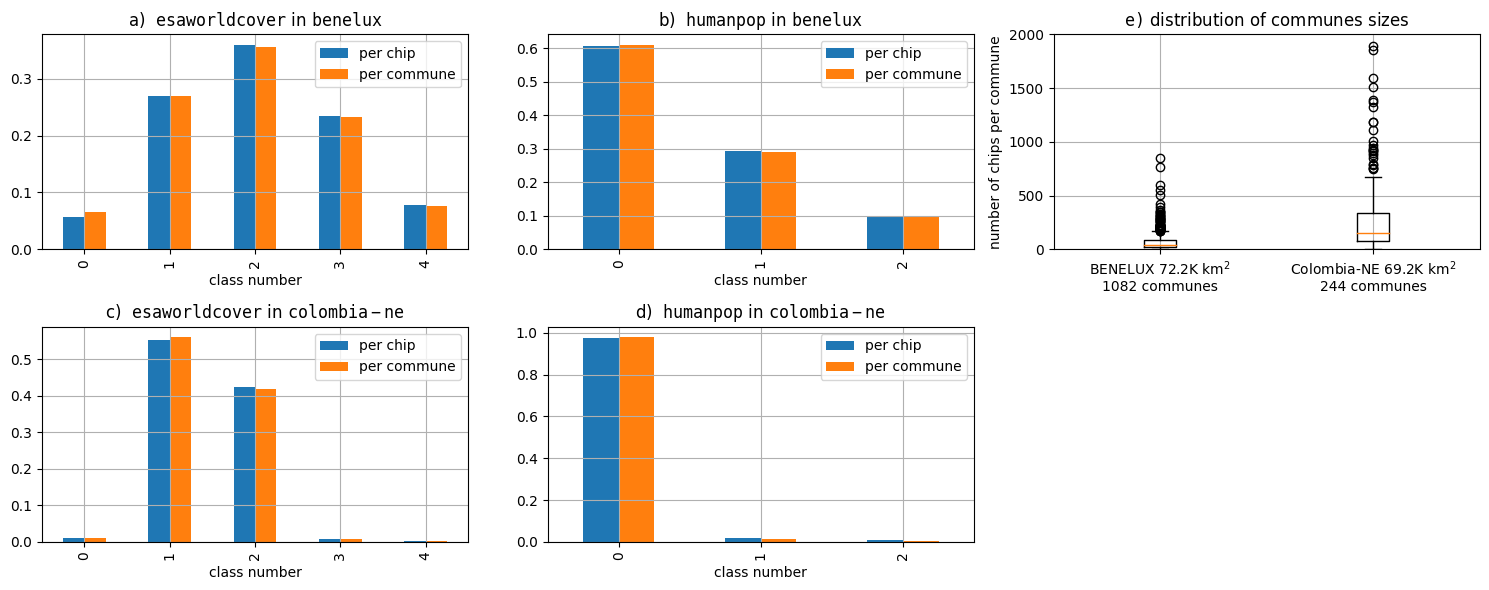

In [36]:
print(flush=True)
for ax,i in subplots(5, usizex=5, n_cols=3):
    if i==0: plot_distribution(be, r'a)  $\tt{esaworldcover}$ in $\tt{benelux}$', ax)
    if i==1: plot_distribution(bh, r'b)  $\tt{humanpop}$ in $\tt{benelux}$', ax)
    if i==3: plot_distribution(ce, r'c)  $\tt{esaworldcover}$ in $\tt{colombia-ne}$', ax)
    if i==4: plot_distribution(ch, r'd)  $\tt{humanpop}$ in $\tt{colombia-ne}$', ax)
    if i==2:
        plt.boxplot([vb, vc])
        plt.xticks(range(1,3), [f"BENELUX {len(b)/1000:.1f}K km$^2$\n{len(vb)} communes", f"Colombia-NE {len(c)/1000:.1f}K km$^2$\n{len(vc)} communes"] )
        plt.grid();
        plt.ylabel("number of chips per commune")
        plt.ylim(0,2000)
        plt.title(r"$\tt{e)}$ distribution of communes sizes")

(0.0, 2000.0)

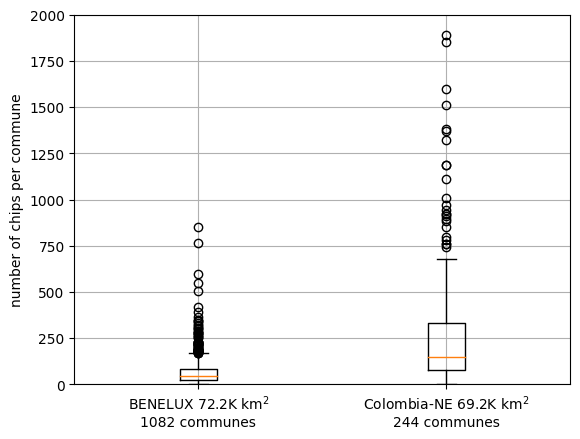

In [10]:

plt.boxplot([vb, vc])
plt.xticks(range(1,3), [f"BENELUX {len(b)/1000:.1f}K km$^2$\n{len(vb)} communes", f"Colombia-NE {len(c)/1000:.1f}K km$^2$\n{len(vc)} communes"] )
plt.grid();
plt.ylabel("number of chips per commune")
plt.ylim(0,2000)

# Model inference over all dataset to create maps with predictions on the area of interest

In [29]:
def get_proportions_inferences_for_split(run, split):
    if split=='train':
        data = run.tr
    elif split=='val':
        data = run.val
    elif split=='test':
        data = run.ts
    else:
        raise ValueError(f'unknown split {split}')
                
    op = []
    lp = []
    pp = []
    cid = []
    for x,(p,l) in pbar(data):
        xx, ll = run.normitem(x,l)
        out = run.model(xx).numpy()
        out_proportions = run.metrics.get_y_pred_as_proportions(out)
        try:
            out_proportions = out_proportions.numpy()
        except:
            pass
        lohe = tf.one_hot(tf.cast(ll, tf.uint8), run.number_of_classes)
        label_proportions = run.metrics.get_y_pred_as_proportions(lohe).numpy()
        chip_ids = [i.split(".")[0] for i in data.batch_chips_basedirs]

        op.append(out_proportions)
        lp.append(label_proportions)
        pp.append(p)
        cid.append(chip_ids)
        

    op = np.r_[op]
    lp = np.r_[lp]
    pp = np.r_[pp]
    cid = np.r_[cid]

    op = op.reshape(-1, op.shape[-1])
    lp = lp.reshape(-1, lp.shape[-1])
    pp = pp.reshape(-1, pp.shape[-1])
    cid = cid.reshape(-1, 1)

    cols = ['identifier'] +\
           [f'true_prop_{i}' for i in range(run.number_of_classes)] + \
           [f'pred_prop_{i}' for i in range(run.number_of_classes)] + \
           [f'train_prop_{i}' for i in range(run.number_of_classes)] 
               
    r = pd.DataFrame(np.hstack([cid, lp, op, pp]), columns = cols)
    r.set_index('identifier', inplace=True)
    return r

def get_inferences(model_file, partitions_id, split_train, split_test, split_val, 
                   cached_data=None, 
                   batch_size=None,
                   data_basedir=None):
    run = runs.Run.load_from(f"/opt/data/models/{modelid}.params")
    
    if cached_data is not None:
        data = cached_data
    else:
        print ("reading metadata", flush=True)
        datafile = [i for i in os.listdir(run.dataloader_split_args['basedir']) if "aschips" in i and i.endswith(".geojson")][0]
        datafile = f"{run.dataloader_split_args['basedir']}/{datafile}"
        data = gpd.read_file(datafile)
        data.set_index('identifier', inplace=True)
        
    run.dataloader_split_method = eval("dataloaders."+run.dataloader_split_method.__qualname__.split(".")[0]+".split")
    run.dataloader_split_args['partitions_id'] = partitions_id
    run.dataloader_split_args['shuffle'] = False
    
    if data_basedir is not None:
        run.dataloader_split_args['basedir']=data_basedir

    print ("loading chips for inference from", run.dataloader_split_args['basedir'])
    
    run.class_weights = None
    if batch_size is not None:
        run.dataloader_split_args['batch_size'] = batch_size
        
    run.initialize()

    infs = []
    if split_train:
        infs.append(get_proportions_inferences_for_split(run, 'train'))
    if split_test:
        infs.append(get_proportions_inferences_for_split(run, 'test'))
    if split_val:
        infs.append(get_proportions_inferences_for_split(run, 'val'))

    alldata = pd.concat( infs )
    v = data.join(alldata.astype(float), how='right').dropna()
    return data, v

def limit_geom(v, lon_range, lat_range):
    k = v.geometry.iloc[0]
    list(k.centroid.coords)[0]
    coords = np.r_[[list(k.centroid.coords)[0] for k in pbar(v.geometry.values)]]
    c0 = coords[:,0]
    c1 = coords[:,1]
    return v[(c0>lon_range[0])&(c0<lon_range[1])&(c1>lat_range[0])&(c1<lat_range[1])]

In [8]:
modelset = colombia_esaworldcover_models_mse
modelset = benelux_esaworldcover_models_mse
modelset = benelux_humanpop_models_mse
modelid = list(modelset.keys())[0]
model_file = f"/opt/data/models/{modelid}.params"
modelid, modelset[modelid]

('jnevh201', 'qmpatch mse')

In [5]:
try:
    _, vchip = get_inferences(model_file, partitions_id='aschip', split_train=True, split_test=True, split_val=True, cached_data=data)
except:
    data, vchip = get_inferences(model_file, partitions_id='aschip', split_train=True, split_test=True, split_val=True)

_, vcomm = get_inferences(model_file, partitions_id='communes', split_train=True, split_test=True, split_val=True, cached_data=data)

autoinit on Run
using model QMPatchSegmentation
using partitions communes
using loss mse
reading metadata
got  50549 chips on 6318 batches. cache size is 700
got  14442 chips on 1805 batches. cache size is 200
got   7222 chips on 902 batches. cache size is 100
got default class weights from dataloader: OrderedDict([(0, 0.1), ((1, 2, 3, 4, 5, 6, 7, 8, 9), 1), ((10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30), 1)])
autoinit on QMPatchSegmentation
setting input shape to (96, 96, 3)
4/4 [==============================] - 0s 9ms/step


  0% (7 of 6318) |                       | Elapsed Time: 0:00:00 ETA:   0:01:31

sigma: 1.2232697010040283
restoring model weights from file


100% (6318 of 6318) |####################| Elapsed Time: 0:02:25 Time:  0:02:25
100% (1805 of 1805) |####################| Elapsed Time: 0:00:42 Time:  0:00:42
100% (902 of 902) |######################| Elapsed Time: 0:00:18 Time:  0:00:18


autoinit on Run
using model QMPatchSegmentation
using partitions communes
using loss mse
got  50549 chips on 6318 batches. cache size is 700
got  14442 chips on 1805 batches. cache size is 200
got   7222 chips on 902 batches. cache size is 100
got default class weights from dataloader: OrderedDict([(0, 0.1), ((1, 2, 3, 4, 5, 6, 7, 8, 9), 1), ((10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30), 1)])
autoinit on QMPatchSegmentation
setting input shape to (96, 96, 3)
4/4 [==============================] - 0s 11ms/step


  0% (0 of 6318) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

sigma: 1.2232697010040283
restoring model weights from file


100% (6318 of 6318) |####################| Elapsed Time: 0:02:23 Time:  0:02:23
100% (1805 of 1805) |####################| Elapsed Time: 0:00:41 Time:  0:00:41
100% (902 of 902) |######################| Elapsed Time: 0:00:18 Time:  0:00:18


In [31]:
run = runs.Run.load_from(f"/opt/data/models/{modelid}.params")


autoinit on Run
using model QMPatchSegmentation
using partitions communes
using loss mse


In [12]:
run.dataloader_split_args

{'basedir': '/opt/data/benelux/benelux_sentinel2-rgb-median-2020_humanpop2015',
 'partitions_id': 'communes',
 'batch_size': 8,
 'cache_size': 1000,
 'shuffle': True,
 'max_chips': None}

In [ ]:
data_basedir = '/opt/data/colombia-ne/colombia-ne_sentinel2-rgb-median-2020_humanpop2015/'

In [34]:
v = get_proportions_inferences_for_split(run, 'test')

100% (2188 of 2188) |####################| Elapsed Time: 0:00:50 Time:  0:00:50


In [12]:
# benelux
lonrange, latrange = (4.3, 5.5), (51, 53)
lonrange, latrange = (4., 6.7), (52.1, 52.8)

# colombia
#lonrange, latrange = (-75, -72.5), (6.5, 7.5)

In [13]:
vvchip = limit_geom(vchip, lonrange, latrange)
vvcomm = limit_geom(vcomm, lonrange, latrange)

100% (72200 of 72200) |##################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (72200 of 72200) |##################| Elapsed Time: 0:00:01 Time:  0:00:01


In [14]:
vvchip.shape, vvcomm.shape

((11548, 16), (11548, 16))

In [15]:
run = runs.Run.load_from(f"/opt/data/models/{modelid}.params")
run.initialize()

autoinit on Run
using model QMPatchSegmentation
using partitions communes
using loss mse
got 72213 chips in total
got  45288 chips on 5661 batches. cache size is 627
got  14475 chips on 1809 batches. cache size is 200
got  12450 chips on 1556 batches. cache size is 173
autoinit on QMPatchSegmentation
setting input shape to (96, 96, 3)
4/4 [==============================] - 0s 12ms/step
sigma: 1.4297525882720947
restoring model weights from file


In [17]:
run = runs.Run.load_from(f"/opt/data/models/{modelid}.params")
run.initialize()

# read communes to show them in the map
splits_file = run.tr.basedir+'/../'+[i for i in os.listdir(f"{run.tr.basedir}/..") if i.endswith("splits.csv")][0]
splits = pd.read_csv(splits_file)
valts = splits[splits['split_communes'].isin(['test', 'val'])]
valts.set_index('identifier', inplace=True)
communes_ids = valts.join(data[['geometry', 'foreignid_communes']]).foreignid_communes.values

partitions_id = 'communes'
chips_geometries = vvchip

communes_file = run.tr.basedir+'/../'+[i for i in os.listdir(f"{run.tr.basedir}/..") if i.endswith(f"_{partitions_id}.geojson")][0]
gcomms = gpd.read_file(communes_file)
gcomms = gcomms[gcomms.identifier.isin(communes_ids)]

autoinit on Run
using model QMPatchSegmentation
using partitions communes
using loss mse
got 72213 chips in total
got  45288 chips on 5661 batches. cache size is 627
got  14475 chips on 1809 batches. cache size is 200
got  12450 chips on 1556 batches. cache size is 173
autoinit on QMPatchSegmentation
setting input shape to (96, 96, 3)
4/4 [==============================] - 0s 11ms/step
sigma: 1.4499688148498535
restoring model weights from file


In [27]:
def plot_with_communes(df_inferences, df_communes, col):
    chips_boundary = sh.geometry.GeometryCollection(list(df_inferences.geometry.values)).convex_hull
    _gcomms = gcomms[[i.intersects(chips_boundary) for i in df_communes.geometry]]
    vmin, vmax = np.percentile(df_inferences[col], (5,95))
    m = df_inferences.explore(col, legend=False, style_kwds=dict(stroke=False, fillOpacity=1.), vmin=vmin, vmax=vmax)
    return _gcomms.explore(m=m, legend=False, style_kwds=dict(opacity=0., fillOpacity=0., fillColor='white', weight=2, color='white', height=800))

In [ ]:
plot_with_communes(vvchip, gcomms, 'train_prop_2')
#plot_with_communes(vvchip, gcomms, 'pred_prop_2')
#plot_with_communes(vvcomm, gcomms, 'train_prop_2')


In [ ]:
plot_with_communes(vcomm, gcomms, 'train_prop_2')

In [55]:
bounds = sh.geometry.GeometryCollection(list(vvchip.geometry)).convex_hull
ggcomms = gcomms[[i.intersects(bounds) for i in gcomms.geometry]].copy()
ggcomms['geometry'] = [i.intersection(bounds) for i in ggcomms.geometry]

In [ ]:
ggcomms.explore(legend=False, style_kwds=dict(opacity=1., fillOpacity=0., fillColor='white', weight=2, color='white', height=800),
                tiles='http://www.google.cn/maps/vt?lyrs=s@189&gl=cn&x={x}&y={y}&z={z}', attr='google')

## cross inference on humanpop between benelux and colombia

In [11]:
def apply_model(modelid, basedir):
    model_file = f"/opt/data/models/{modelid}.params"
    
    run = runs.Run.load_from(model_file)
    run.dataloader_split_args['basedir'] = basedir
    run.dataloader_split_args['partitions_id'] = 'aschip'
    print (run.dataloader_split_args)
    run.initialize()
    print (run.model.init_args)
    

    data = run.val
    pixel_classification_metrics = metrics.PixelClassificationMetrics(number_of_classes=run.number_of_classes)
    pixel_classification_metrics.reset_state()

    maes = []
    for x,(p,l) in pbar(data):
        xx, ll = run.normitem(x,l)
        out = run.model(xx).numpy()
        out_proportions = run.metrics.get_y_pred_as_proportions(out)
        out_segmentation = run.model.predict_segmentation(x)
        lohe = tf.one_hot(tf.cast(ll, tf.uint8), run.number_of_classes)
        label_proportions = run.metrics.get_y_pred_as_proportions(lohe).numpy()

        pixel_classification_metrics.update_state(l,out_segmentation)
        maes.append(run.metrics.multiclass_proportions_mae_on_chip(l, out))    


    return {
            'mae': np.mean(maes), 
            'f1': np.mean(pixel_classification_metrics.result('f1', 'micro'))
           }
        

In [12]:
modelid_col  = '2az65ra8' # downconv trained on colombia-ne
modelid_bene = 'g9x7v31k' # downconv trained on benelux

basedir_col = '/opt/data/colombia-ne/colombia-ne_sentinel2-rgb-median-2020_humanpop2015'
basedir_bene = '/opt/data/benelux/benelux_sentinel2-rgb-median-2020_humanpop2015'

In [13]:
humanpop_col2col = apply_model(
    modelid = modelid_col,
    basedir = basedir_col
)

autoinit on Run
using model Custom_DownsamplingSegmentation
using partitions communes
using loss mse
{'basedir': '/opt/data/colombia-ne/colombia-ne_sentinel2-rgb-median-2020_humanpop2015', 'partitions_id': 'aschip', 'batch_size': 8, 'cache_size': 1000, 'shuffle': True, 'max_chips': None}
got 69193 chips in total
got  34715 chips on 4339 batches. cache size is 501
got  17506 chips on 2188 batches. cache size is 253
got  16972 chips on 2121 batches. cache size is 246
autoinit on Custom_DownsamplingSegmentation
setting input shape to (96, 96, 3)
convlayer {'kernel_size': 8, 'filters': 32, 'activation': 'relu', 'padding': 'valid', 'strides': 4, 'dropout': 0.1}


  0% (3 of 2121) |                       | Elapsed Time: 0:00:00 ETA:   0:01:31

restoring model weights from file
{'conv_layers': ListWrapper([DictWrapper({'kernel_size': 8, 'filters': 32, 'activation': 'relu', 'padding': 'valid', 'strides': 4, 'dropout': 0.1})]), 'use_alexnet_weights': False, 'number_of_classes': 3}


100% (2121 of 2121) |####################| Elapsed Time: 0:01:04 Time:  0:01:04


In [14]:
humanpop_bene2col = apply_model(
    modelid = modelid_bene,
    basedir = basedir_col
)

autoinit on Run
using model Custom_DownsamplingSegmentation
using partitions communes
using loss mse
{'basedir': '/opt/data/colombia-ne/colombia-ne_sentinel2-rgb-median-2020_humanpop2015', 'partitions_id': 'aschip', 'batch_size': 32, 'cache_size': 1000, 'shuffle': True, 'max_chips': None}
got 69193 chips in total
got  34715 chips on 1084 batches. cache size is 501
got  17506 chips on 547 batches. cache size is 253
got  16972 chips on 530 batches. cache size is 246
autoinit on Custom_DownsamplingSegmentation
setting input shape to (96, 96, 3)
convlayer {'kernel_size': 4, 'filters': 96, 'activation': 'relu', 'padding': 'valid', 'strides': 4, 'dropout': 0.1}
restoring model weights from file


  0% (2 of 530) |                        | Elapsed Time: 0:00:00 ETA:   0:00:36

{'conv_layers': ListWrapper([DictWrapper({'kernel_size': 4, 'filters': 96, 'activation': 'relu', 'padding': 'valid', 'strides': 4, 'dropout': 0.1})]), 'use_alexnet_weights': False, 'number_of_classes': 3}


100% (530 of 530) |######################| Elapsed Time: 0:00:34 Time:  0:00:34


In [15]:
humanpop_bene2bene = apply_model(
    modelid = modelid_bene,
    basedir = basedir_bene
)

autoinit on Run
using model Custom_DownsamplingSegmentation
using partitions communes
using loss mse
{'basedir': '/opt/data/benelux/benelux_sentinel2-rgb-median-2020_humanpop2015', 'partitions_id': 'aschip', 'batch_size': 32, 'cache_size': 1000, 'shuffle': True, 'max_chips': None}
got 72213 chips in total
got  43092 chips on 1346 batches. cache size is 596
got  15011 chips on 469 batches. cache size is 207
got  14110 chips on 440 batches. cache size is 197
autoinit on Custom_DownsamplingSegmentation
setting input shape to (96, 96, 3)
convlayer {'kernel_size': 4, 'filters': 96, 'activation': 'relu', 'padding': 'valid', 'strides': 4, 'dropout': 0.1}


  0% (0 of 440) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

restoring model weights from file
{'conv_layers': ListWrapper([DictWrapper({'kernel_size': 4, 'filters': 96, 'activation': 'relu', 'padding': 'valid', 'strides': 4, 'dropout': 0.1})]), 'use_alexnet_weights': False, 'number_of_classes': 3}


100% (440 of 440) |######################| Elapsed Time: 0:00:36 Time:  0:00:36


In [16]:
humanpop_col2bene = apply_model(
    modelid = modelid_col,
    basedir = basedir_bene
)

autoinit on Run
using model Custom_DownsamplingSegmentation
using partitions communes
using loss mse
{'basedir': '/opt/data/benelux/benelux_sentinel2-rgb-median-2020_humanpop2015', 'partitions_id': 'aschip', 'batch_size': 8, 'cache_size': 1000, 'shuffle': True, 'max_chips': None}
got 72213 chips in total
got  43092 chips on 5386 batches. cache size is 596
got  15011 chips on 1876 batches. cache size is 207
got  14110 chips on 1763 batches. cache size is 197
autoinit on Custom_DownsamplingSegmentation
setting input shape to (96, 96, 3)
convlayer {'kernel_size': 8, 'filters': 32, 'activation': 'relu', 'padding': 'valid', 'strides': 4, 'dropout': 0.1}


  0% (0 of 1763) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

restoring model weights from file
{'conv_layers': ListWrapper([DictWrapper({'kernel_size': 8, 'filters': 32, 'activation': 'relu', 'padding': 'valid', 'strides': 4, 'dropout': 0.1})]), 'use_alexnet_weights': False, 'number_of_classes': 3}


100% (1763 of 1763) |####################| Elapsed Time: 0:00:48 Time:  0:00:48


In [19]:
pd.DataFrame([humanpop_col2col, humanpop_col2bene, humanpop_bene2bene, humanpop_bene2col], 
             index=['col2col', 'col2bene', 'bene2bene', 'bene2col'])

,mae,f1
col2col,0.019376,0.970935
col2bene,0.259233,0.611151
bene2bene,0.138296,0.607048
bene2col,0.192234,0.692295


## cross inference on esa world cover between benelux and colombia

In [21]:
modelid_col  = 'eimikgrw' # downconv trained on colombia-ne
modelid_bene = '18uwzkax' # downconv trained on benelux

basedir_col = '/opt/data/colombia-ne/colombia-ne_sentinel2-rgb-median-2020_esa-world-cover'
basedir_bene = '/opt/data/benelux/benelux_sentinel2-rgb-median-2020_esa-world-cover'


In [22]:
ewc_col2col = apply_model(
    modelid = modelid_col,
    basedir = basedir_col
)

autoinit on Run
using model Custom_DownsamplingSegmentation
using partitions communes
using loss mse
{'basedir': '/opt/data/colombia-ne/colombia-ne_sentinel2-rgb-median-2020_esa-world-cover', 'partitions_id': 'aschip', 'batch_size': 32, 'cache_size': 1000, 'shuffle': True, 'max_chips': None}
got 69193 chips in total
got  34715 chips on 1084 batches. cache size is 501
got  17506 chips on 547 batches. cache size is 253
got  16972 chips on 530 batches. cache size is 246
autoinit on Custom_DownsamplingSegmentation
setting input shape to (96, 96, 3)
convlayer {'kernel_size': 4, 'filters': 96, 'activation': 'relu', 'padding': 'valid', 'strides': 4, 'dropout': 0.1}


  0% (0 of 530) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

restoring model weights from file
{'conv_layers': ListWrapper([DictWrapper({'kernel_size': 4, 'filters': 96, 'activation': 'relu', 'padding': 'valid', 'strides': 4, 'dropout': 0.1})]), 'use_alexnet_weights': False, 'number_of_classes': 5}


100% (530 of 530) |######################| Elapsed Time: 0:00:47 Time:  0:00:47


In [23]:
ewc_col2bene = apply_model(
    modelid = modelid_col,
    basedir = basedir_bene
)

autoinit on Run
using model Custom_DownsamplingSegmentation
using partitions communes
using loss mse
{'basedir': '/opt/data/benelux/benelux_sentinel2-rgb-median-2020_esa-world-cover', 'partitions_id': 'aschip', 'batch_size': 32, 'cache_size': 1000, 'shuffle': True, 'max_chips': None}
got 72213 chips in total
got  43092 chips on 1346 batches. cache size is 596
got  15011 chips on 469 batches. cache size is 207
got  14110 chips on 440 batches. cache size is 197
autoinit on Custom_DownsamplingSegmentation
setting input shape to (96, 96, 3)
convlayer {'kernel_size': 4, 'filters': 96, 'activation': 'relu', 'padding': 'valid', 'strides': 4, 'dropout': 0.1}
restoring model weights from file
{'conv_layers': ListWrapper([DictWrapper({'kernel_size': 4, 'filters': 96, 'activation': 'relu', 'padding': 'valid', 'strides': 4, 'dropout': 0.1})]), 'use_alexnet_weights': False, 'number_of_classes': 5}


100% (440 of 440) |######################| Elapsed Time: 0:00:40 Time:  0:00:40


In [24]:
ewc_bene2col = apply_model(
    modelid = modelid_bene,
    basedir = basedir_col
)

autoinit on Run
using model Custom_DownsamplingSegmentation
using partitions communes
using loss mse
{'basedir': '/opt/data/colombia-ne/colombia-ne_sentinel2-rgb-median-2020_esa-world-cover', 'partitions_id': 'aschip', 'batch_size': 32, 'cache_size': 1000, 'shuffle': True, 'max_chips': None}
got 69193 chips in total
got  34715 chips on 1084 batches. cache size is 501
got  17506 chips on 547 batches. cache size is 253
got  16972 chips on 530 batches. cache size is 246
autoinit on Custom_DownsamplingSegmentation
setting input shape to (96, 96, 3)
convlayer {'kernel_size': 4, 'filters': 96, 'activation': 'relu', 'padding': 'valid', 'strides': 4, 'dropout': 0.1}
restoring model weights from file
{'conv_layers': ListWrapper([DictWrapper({'kernel_size': 4, 'filters': 96, 'activation': 'relu', 'padding': 'valid', 'strides': 4, 'dropout': 0.1})]), 'use_alexnet_weights': False, 'number_of_classes': 5}


100% (530 of 530) |######################| Elapsed Time: 0:00:47 Time:  0:00:47


In [25]:
ewc_bene2bene = apply_model(
    modelid = modelid_bene,
    basedir = basedir_bene
)

autoinit on Run
using model Custom_DownsamplingSegmentation
using partitions communes
using loss mse
{'basedir': '/opt/data/benelux/benelux_sentinel2-rgb-median-2020_esa-world-cover', 'partitions_id': 'aschip', 'batch_size': 32, 'cache_size': 1000, 'shuffle': True, 'max_chips': None}
got 72213 chips in total
got  43092 chips on 1346 batches. cache size is 596
got  15011 chips on 469 batches. cache size is 207
got  14110 chips on 440 batches. cache size is 197
autoinit on Custom_DownsamplingSegmentation
setting input shape to (96, 96, 3)
convlayer {'kernel_size': 4, 'filters': 96, 'activation': 'relu', 'padding': 'valid', 'strides': 4, 'dropout': 0.1}
restoring model weights from file
{'conv_layers': ListWrapper([DictWrapper({'kernel_size': 4, 'filters': 96, 'activation': 'relu', 'padding': 'valid', 'strides': 4, 'dropout': 0.1})]), 'use_alexnet_weights': False, 'number_of_classes': 5}


100% (440 of 440) |######################| Elapsed Time: 0:00:39 Time:  0:00:39


In [28]:
pd.DataFrame([ewc_col2col, ewc_bene2col,  ewc_bene2bene, ewc_col2bene], 
             index=['col2col', 'bene2col', 'bene2bene', 'col2bene'])

,mae,f1
col2col,0.073652,0.769696
bene2col,0.181102,0.395949
bene2bene,0.067358,0.633741
col2bene,0.226431,0.296734


# Areas of interest

## Benelux

In [ ]:
import geopandas as gpd
import shapely as sh
from progressbar import progressbar as pbar
from pyproj import CRS

z = gpd.read_file("/opt/data/benelux/benelux_partitions_aschips_32731750caf26.geojson")


In [ ]:
k = z.geometry.iloc[0]
list(k.centroid.coords)[0]
coords = np.r_[[list(k.centroid.coords)[0] for k in pbar(z.geometry.values)]]
z['c0'] = coords[:,0]
z['c1'] = coords[:,1]


In [ ]:
zz = z[(z.c0>4.6)&(z.c0<5.1)&(z.c1>52.3)&(z.c1<52.45)][['geometry', 'c0', 'c1']]

In [ ]:
zz.explore(legend=True, style_kwds=dict(color="white",weight=1, opacity=0.5, fillOpacity=0.0),
          
           tiles = 'http://www.google.cn/maps/vt?lyrs=s@189&gl=cn&x={x}&y={y}&z={z}',
           attr = 'google')


In [ ]:
zc = gpd.read_file("/opt/data/benelux/benelux_partitions_communes_09c449b816c78.geojson")
zc.explore(legend=True, style_kwds=dict(color="blue",weight=1, opacity=0.4, fillOpacity=0.0), tiles='CartoDB positron')

In [ ]:
z['split_nb'] = [0 if i=='train' else 1 if i=='val' else 2 for i in z.split_communes]
z.explore(column='split_nb', tooltip=False)

In [ ]:
with open("/opt/data/benelux/benelux.wkt") as f:
    w = sh.wkt.load(f)
    
gpd.GeoDataFrame([[w]], columns=['geometry'], crs=CRS.from_epsg(4326)).explore()

## Colombia

In [ ]:
with open("/opt/data/colombia-ne/colombia-ne.wkt") as f:
    w = sh.wkt.load(f)
    
gpd.GeoDataFrame([[w]], columns=['geometry'], crs=CRS.from_epsg(4326)).explore()

In [ ]:
z = gpd.read_file("/opt/data/colombia-ne/colombia-ne_partitions_aschips_37fb444c2342f.geojson")


In [ ]:
k = z.geometry.iloc[0]
list(k.centroid.coords)[0]
coords = np.r_[[list(k.centroid.coords)[0] for k in pbar(z.geometry.values)]]
z['c0'] = coords[:,0]
z['c1'] = coords[:,1]


In [ ]:
coords.min(axis=0), coords.max(axis=0)

In [ ]:
zz = z[(z.c0>-73.4)&(z.c0<-73.05)&(z.c1>7.05)&(z.c1<7.2)][['geometry', 'c0', 'c1']]
#zz = z[['geometry', 'c0', 'c1']]
zz.shape

In [ ]:
zz.explore(legend=True, style_kwds=dict(color="white",weight=1, opacity=0.5, fillOpacity=0.0),
          tiles = 'http://www.google.cn/maps/vt?lyrs=s@189&gl=cn&x={x}&y={y}&z={z}',
          attr = 'google')


In [ ]:
zc = gpd.read_file("/opt/data/colombia-ne/colombia-ne_partitions_communes_35ca725dacdbc.geojson")
zc['geometry'] = [i.intersection(w) for i in zc.geometry]

In [ ]:
zc.explore(legend=True, style_kwds=dict(color="blue",weight=1, opacity=0.4, fillOpacity=0.0), tiles='CartoDB positron')

In [ ]:
import pandas as pd
gpd.GeoDataFrame(pd.DataFrame([list(zc.geometry.values)+[w]], index=['geometry']).T, crs=zc.crs)

In [ ]:
z['split_nb'] = [0 if i=='train' else 1 if i=='val' else 2 for i in z.split_communes]
z.explore(column='split_nb', tooltip=False)

# example commune in Benelux

In [62]:
from skimage.io import imread
import pickle

In [7]:
zc = gpd.read_file("/opt/data/benelux/benelux_partitions_communes_09c449b816c78.geojson")


In [51]:
folder = "/opt/data/benelux/benelux_partitions_communes_09c449b816c78/sentinel2-rgb-median-2020"
files = os.listdir(folder)
file = np.random.choice(files)
img = imread(f"{folder}/{file}")

'0fa5ea0729f5a.tif'

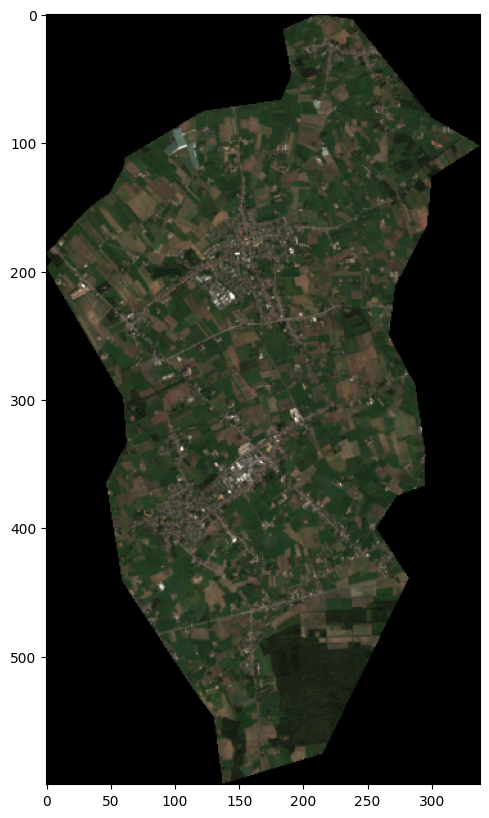

In [52]:
plt.figure(figsize=(10,10))
plt.imshow(img)

In [59]:
commune_id = file.split(".")[0]
commune_id

'0fa5ea0729f5a'

In [50]:
'343377ff2151e', '0a220643bbbe7', '2863c8915250c', '0fa5ea0729f5a'

('343377ff2151e', '0a220643bbbe7', '2863c8915250c')

In [53]:
zh = gpd.read_file("/opt/data/benelux/benelux_partitions_aschips_32731750caf26.geojson")


In [112]:
zz = zh[zh.foreignid_communes==commune_id]

In [181]:
d = dataloaders.S2_ESAWorldCover_DataLoader(basedir='/opt/data/benelux/benelux_sentinel2-rgb-median-2020_esa-world-cover', partitions_id='communes')

got  72213 chips on 2256 batches. cache size is 100


In [184]:
x, (p,l) = d.get_by_ids(zz.identifier.values)

In [146]:
def plot_labels(d,ids):
    x, (p,l) = d.get_by_ids(ids)
    n_cols = 8 if len(x)>8 else len(x)
    for ax,i in subplots((len(x)+1)*2, n_cols=n_cols):
        row = i//n_cols
        col = i%n_cols

        if row%2==0:
            #print (col+8*row//2)
            idx = col+8*row//2
            if idx<len(x):
                plt.imshow(x[idx])
                plt.title(f"{idx} - {zz.identifier.values[idx]}")
        else:        
            idx = col+8*(row//2)
            if idx<len(x):
                plt.imshow(l[idx], vmin=0, vmax=4)
        plt.axis("off")

In [ ]:
plot_labels(d,zz.identifier.values)

In [174]:
selected_ids = [15, 19, 2, 44]
selected_ids = [zz.identifier.values[i] for i in selected_ids]
selected_ids

['31f0c6fbf85fe', '306f600436d2c', '006c47afde9e5', '200fba0f1f4fd']